In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

In [3]:
data = pd.read_csv('/Users/harashimakoshi/CS332/332Project2/data/espace_5stores_daily_2024_2025.csv')

In [4]:
# 指数平滑化を行う
# データを[0,1]の範囲に収まるようにする

def exponential_smoothing(series, alpha=0.3):
    '''Apply exponential smoothing to a time series'''
    smoothed = np.zeros_like(series)
    smoothed[0] = series[0]
    for i in range(1, len(series)):
        smoothed[i] = alpha * series[i] + (1 - alpha) * smoothed[i-1]
    return smoothed

def normalize_to_01(series):
    '''Normalize series to [0,1] range'''
    min_val = series.min()
    max_val = series.max()
    if max_val == min_val:
        return np.zeros_like(series)
    return (series - min_val) / (max_val - min_val)

# Process each store
stores = data['store'].unique()
processed_data = []

for store in stores:
    store_data = data[data['store'] == store].copy()
    
    # Apply exponential smoothing to ROI
    store_data['roi_smoothed'] = exponential_smoothing(store_data['roi'].values)
    
    # Normalize smoothed ROI to [0,1]
    store_data['roi_normalized'] = normalize_to_01(store_data['roi_smoothed'])
    
    # Also normalize avg_diff to [0,1]
    store_data['avg_diff_normalized'] = normalize_to_01(store_data['avg_diff'].values)
    
    processed_data.append(store_data)

# Combine all processed data
final_data = pd.concat(processed_data, ignore_index=True)

print('Data processing completed!')
print(f'Final data shape: {final_data.shape}')
print('\nFirst few rows of processed data:')
print(final_data.head())

print('\nSummary statistics for normalized ROI:')
print(final_data.groupby('store')['roi_normalized'].describe())

# Save the processed data
output_path = '/Users/harashimakoshi/CS332/332Project2/data/espace_5stores_normalized.csv'
final_data.to_csv(output_path, index=False)
print(f'\nProcessed data saved to: {output_path}')

Data processing completed!
Final data shape: (1825, 7)

First few rows of processed data:
   day    store    avg_diff       roi  roi_smoothed  roi_normalized  \
0    0  Store_A  112.734361  0.112734      0.112734        0.320206   
1    1  Store_A  135.714578  0.135715      0.119628        0.370894   
2    2  Store_A  139.016797  0.139017      0.125445        0.413659   
3    3  Store_A  150.885228  0.150885      0.133077        0.469773   
4    4  Store_A  134.983610  0.134984      0.133649        0.473978   

   avg_diff_normalized  
0             0.448600  
1             0.525768  
2             0.536857  
3             0.576712  
4             0.523313  

Summary statistics for normalized ROI:
         count      mean       std  min       25%       50%       75%  max
store                                                                     
Store_A  365.0  0.596118  0.181010  0.0  0.473978  0.593029  0.728956  1.0
Store_B  365.0  0.532896  0.166800  0.0  0.409684  0.545978  0.65377

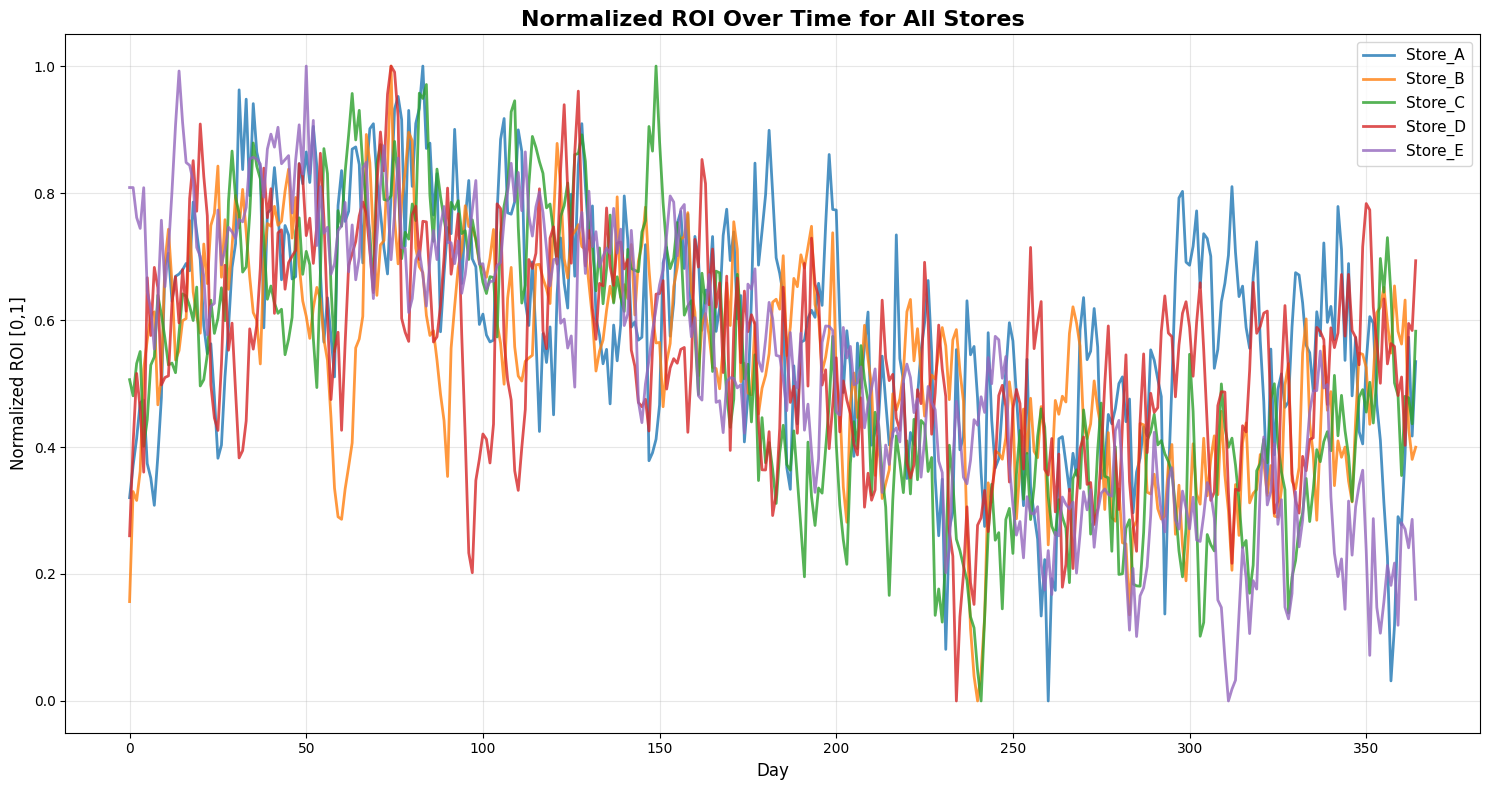

時系列グラフが生成されました！
保存先: /Users/harashimakoshi/CS332/332Project2/figures/normalized_roi_timeseries.png


In [7]:
# 時系列グラフで5つの店舗の正規化されたROIを表示
plt.figure(figsize=(15, 8))

# 各店舗の色を設定
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
store_names = final_data['store'].unique()

for i, store in enumerate(store_names):
    store_data = final_data[final_data['store'] == store]
    plt.plot(store_data['day'], store_data['roi_normalized'], 
             label=store, color=colors[i], linewidth=2, alpha=0.8)

plt.title('Normalized ROI Over Time for All Stores', fontsize=16, fontweight='bold')
plt.xlabel('Day', fontsize=12)
plt.ylabel('Normalized ROI [0,1]', fontsize=12)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# グラフを保存
plt.savefig('/Users/harashimakoshi/CS332/332Project2/figures/normalized_roi_timeseries.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("時系列グラフが生成されました！")
print("保存先: /Users/harashimakoshi/CS332/332Project2/figures/normalized_roi_timeseries.png")


=== 各店舗の正規化されたROIの平均値 ===

Store_A: 0.5961
Store_D: 0.5453
Store_B: 0.5329
Store_E: 0.5244
Store_C: 0.5209

=== 平均値のランキング ===
1. Store_A: 0.5961
2. Store_D: 0.5453
3. Store_B: 0.5329
4. Store_E: 0.5244
5. Store_C: 0.5209

=== 統計サマリー ===
全体平均: 0.5439
最高平均: 0.5961 (Store_A)
最低平均: 0.5209 (Store_C)
標準偏差: 0.0307


/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_1784/911268897.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(store_data_list, labels=store_averages.index)


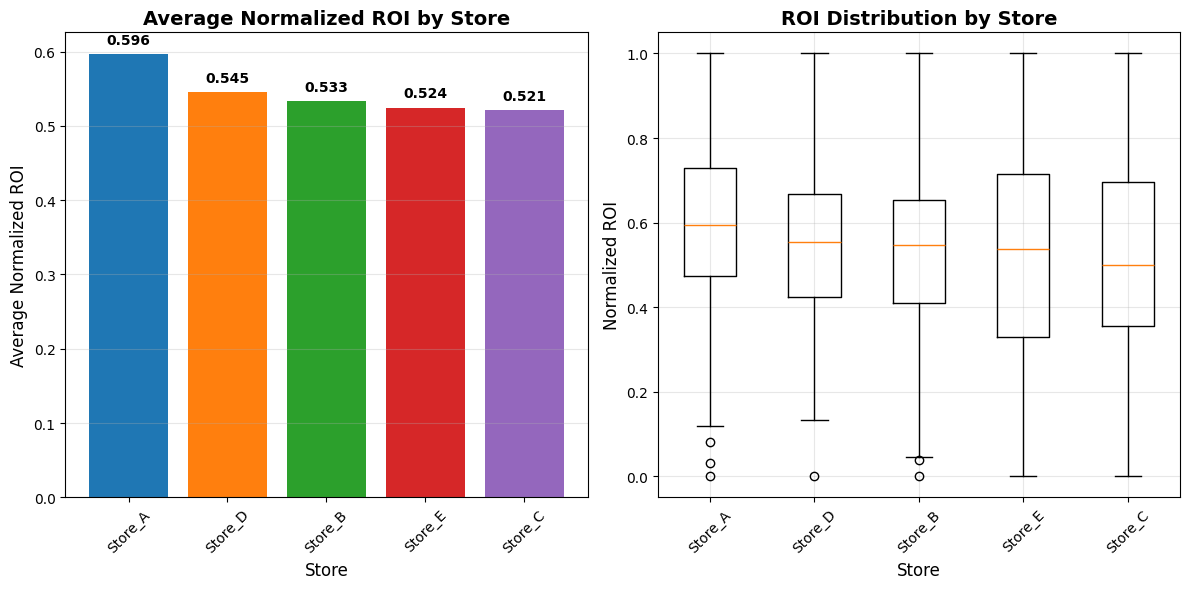


平均値分析グラフが生成されました！
保存先: /Users/harashimakoshi/CS332/332Project2/figures/store_averages_analysis.png


In [8]:
# 各店舗の正規化されたROIの平均を計算
print("=== 各店舗の正規化されたROIの平均値 ===")
print()

store_averages = final_data.groupby('store')['roi_normalized'].mean().sort_values(ascending=False)

for store, avg_roi in store_averages.items():
    print(f"{store}: {avg_roi:.4f}")

print()
print("=== 平均値のランキング ===")
for i, (store, avg_roi) in enumerate(store_averages.items(), 1):
    print(f"{i}. {store}: {avg_roi:.4f}")

print()
print("=== 統計サマリー ===")
print(f"全体平均: {final_data['roi_normalized'].mean():.4f}")
print(f"最高平均: {store_averages.max():.4f} ({store_averages.idxmax()})")
print(f"最低平均: {store_averages.min():.4f} ({store_averages.idxmin()})")
print(f"標準偏差: {store_averages.std():.4f}")

# 平均値を可視化
plt.figure(figsize=(12, 6))

# バープロット
plt.subplot(1, 2, 1)
bars = plt.bar(range(len(store_averages)), store_averages.values, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.title('Average Normalized ROI by Store', fontsize=14, fontweight='bold')
plt.xlabel('Store', fontsize=12)
plt.ylabel('Average Normalized ROI', fontsize=12)
plt.xticks(range(len(store_averages)), store_averages.index, rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# バーの上に値を表示
for i, (bar, value) in enumerate(zip(bars, store_averages.values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 箱ひげ図
plt.subplot(1, 2, 2)
store_data_list = [final_data[final_data['store'] == store]['roi_normalized'].values 
                   for store in store_averages.index]
plt.boxplot(store_data_list, labels=store_averages.index)
plt.title('ROI Distribution by Store', fontsize=14, fontweight='bold')
plt.xlabel('Store', fontsize=12)
plt.ylabel('Normalized ROI', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/harashimakoshi/CS332/332Project2/figures/store_averages_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n平均値分析グラフが生成されました！")
print("保存先: /Users/harashimakoshi/CS332/332Project2/figures/store_averages_analysis.png")


=== 最初の100日 vs 最後の100日の比較 ===

Store_A:
  最初の100日平均: 0.7141
  最後の100日平均: 0.5271
  変化量: -0.1870 (-26.18%)

Store_B:
  最初の100日平均: 0.6394
  最後の100日平均: 0.4032
  変化量: -0.2361 (-36.93%)

Store_C:
  最初の100日平均: 0.7013
  最後の100日平均: 0.3663
  変化量: -0.3351 (-47.78%)

Store_D:
  最初の100日平均: 0.6466
  最後の100日平均: 0.4842
  変化量: -0.1624 (-25.12%)

Store_E:
  最初の100日平均: 0.7580
  最後の100日平均: 0.2666
  変化量: -0.4914 (-64.83%)

=== 全体サマリー ===
全体の最初の100日平均: 0.6919
全体の最後の100日平均: 0.4095


/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_1784/1755036932.py:123: UserWarning: Glyph 24215 (\N{CJK UNIFIED IDEOGRAPH-5E97}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_1784/1755036932.py:123: UserWarning: Glyph 33303 (\N{CJK UNIFIED IDEOGRAPH-8217}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_1784/1755036932.py:123: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_1784/1755036932.py:123: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_1784/1755036932.py:123: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/my/j3wj

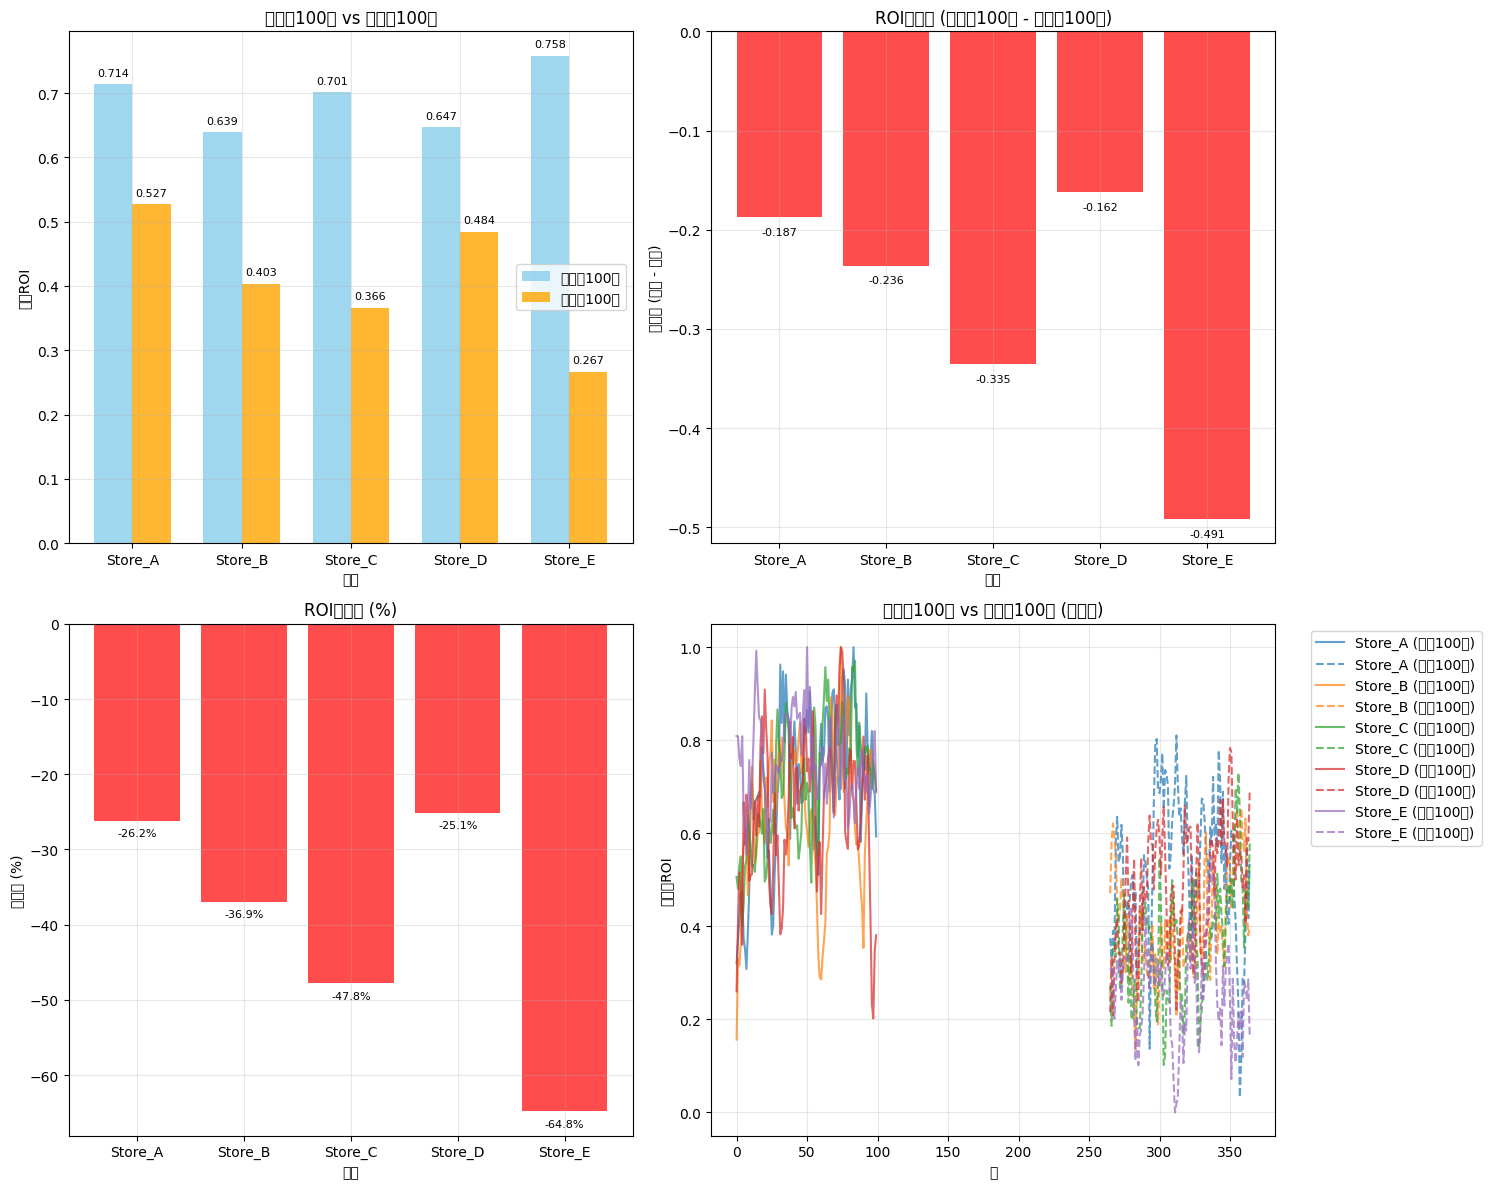

最初の100日 vs 最後の100日の比較グラフが生成されました！
保存先: /Users/harashimakoshi/CS332/332Project2/figures/first_vs_last_100days_comparison.png


In [9]:
# 最初の100日と最後の100日の平均を比較
print("=== 最初の100日 vs 最後の100日の比較 ===")
print()

# 各店舗の最初の100日と最後の100日のデータを取得
comparison_results = []

for store in final_data['store'].unique():
    store_data = final_data[final_data['store'] == store].sort_values('day')
    
    # 最初の100日
    first_100 = store_data.head(100)['roi_normalized'].mean()
    
    # 最後の100日
    last_100 = store_data.tail(100)['roi_normalized'].mean()
    
    # 変化量
    change = last_100 - first_100
    change_pct = (change / first_100) * 100 if first_100 != 0 else 0
    
    comparison_results.append({
        'store': store,
        'first_100_avg': first_100,
        'last_100_avg': last_100,
        'change': change,
        'change_pct': change_pct
    })
    
    print(f"{store}:")
    print(f"  最初の100日平均: {first_100:.4f}")
    print(f"  最後の100日平均: {last_100:.4f}")
    print(f"  変化量: {change:+.4f} ({change_pct:+.2f}%)")
    print()

# データフレームに変換
comparison_df = pd.DataFrame(comparison_results)

print("=== 全体サマリー ===")
print(f"全体の最初の100日平均: {final_data[final_data['day'] < 100]['roi_normalized'].mean():.4f}")
print(f"全体の最後の100日平均: {final_data[final_data['day'] >= 265]['roi_normalized'].mean():.4f}")

# 可視化
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 各店舗の比較バープロット
ax1 = axes[0, 0]
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax1.bar(x - width/2, comparison_df['first_100_avg'], width, 
                label='最初の100日', alpha=0.8, color='skyblue')
bars2 = ax1.bar(x + width/2, comparison_df['last_100_avg'], width, 
                label='最後の100日', alpha=0.8, color='orange')

ax1.set_xlabel('店舗')
ax1.set_ylabel('平均ROI')
ax1.set_title('最初の100日 vs 最後の100日')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['store'])
ax1.legend()
ax1.grid(True, alpha=0.3)

# バーの上に値を表示
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    ax1.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.01, 
             f'{comparison_df.iloc[i]["first_100_avg"]:.3f}', 
             ha='center', va='bottom', fontsize=8)
    ax1.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.01, 
             f'{comparison_df.iloc[i]["last_100_avg"]:.3f}', 
             ha='center', va='bottom', fontsize=8)

# 2. 変化量のバープロット
ax2 = axes[0, 1]
colors = ['green' if x > 0 else 'red' for x in comparison_df['change']]
bars = ax2.bar(comparison_df['store'], comparison_df['change'], color=colors, alpha=0.7)
ax2.set_xlabel('店舗')
ax2.set_ylabel('変化量 (最後 - 最初)')
ax2.set_title('ROI変化量 (最後の100日 - 最初の100日)')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.grid(True, alpha=0.3)

# バーの上に値を表示
for i, (bar, value) in enumerate(zip(bars, comparison_df['change'])):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.01 if value > 0 else -0.01), 
             f'{value:+.3f}', ha='center', va='bottom' if value > 0 else 'top', fontsize=8)

# 3. 変化率のバープロット
ax3 = axes[1, 0]
colors = ['green' if x > 0 else 'red' for x in comparison_df['change_pct']]
bars = ax3.bar(comparison_df['store'], comparison_df['change_pct'], color=colors, alpha=0.7)
ax3.set_xlabel('店舗')
ax3.set_ylabel('変化率 (%)')
ax3.set_title('ROI変化率 (%)')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.grid(True, alpha=0.3)

# バーの上に値を表示
for i, (bar, value) in enumerate(zip(bars, comparison_df['change_pct'])):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (1 if value > 0 else -1), 
             f'{value:+.1f}%', ha='center', va='bottom' if value > 0 else 'top', fontsize=8)

# 4. 時系列での比較（最初の100日と最後の100日を重ねて表示）
ax4 = axes[1, 1]
for i, store in enumerate(final_data['store'].unique()):
    store_data = final_data[final_data['store'] == store].sort_values('day')
    
    # 最初の100日
    first_100_data = store_data.head(100)
    ax4.plot(first_100_data['day'], first_100_data['roi_normalized'], 
             color=f'C{i}', linestyle='-', alpha=0.7, label=f'{store} (最初100日)')
    
    # 最後の100日（x軸を調整）
    last_100_data = store_data.tail(100)
    ax4.plot(last_100_data['day'], last_100_data['roi_normalized'], 
             color=f'C{i}', linestyle='--', alpha=0.7, label=f'{store} (最後100日)')

ax4.set_xlabel('日')
ax4.set_ylabel('正規化ROI')
ax4.set_title('最初の100日 vs 最後の100日 (時系列)')
ax4.grid(True, alpha=0.3)
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('/Users/harashimakoshi/CS332/332Project2/figures/first_vs_last_100days_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("最初の100日 vs 最後の100日の比較グラフが生成されました！")
print("保存先: /Users/harashimakoshi/CS332/332Project2/figures/first_vs_last_100days_comparison.png")


=== Store_Aを除いた分析 ===

元のデータ数: 1825
Store_Aを除いたデータ数: 1460
除外されたデータ数: 365

=== Store_Aを除いた各店舗の平均ROI ===
Store_D: 0.5453
Store_B: 0.5329
Store_E: 0.5244
Store_C: 0.5209

=== 平均値のランキング (Store_A除く) ===
1. Store_D: 0.5453
2. Store_B: 0.5329
3. Store_E: 0.5244
4. Store_C: 0.5209

=== 統計サマリー (Store_A除く) ===
全体平均: 0.5309
最高平均: 0.5453 (Store_D)
最低平均: 0.5209 (Store_C)
標準偏差: 0.0109

=== Store_Aを除いた最初の100日 vs 最後の100日の比較 ===
Store_B:
  最初の100日平均: 0.6394
  最後の100日平均: 0.4032
  変化量: -0.2361 (-36.93%)

Store_C:
  最初の100日平均: 0.7013
  最後の100日平均: 0.3663
  変化量: -0.3351 (-47.78%)

Store_D:
  最初の100日平均: 0.6466
  最後の100日平均: 0.4842
  変化量: -0.1624 (-25.12%)

Store_E:
  最初の100日平均: 0.7580
  最後の100日平均: 0.2666
  変化量: -0.4914 (-64.83%)



/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_1784/976578184.py:119: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(store_data_list_no_a, labels=store_averages_no_a.index)
/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_1784/976578184.py:126: UserWarning: Glyph 38500 (\N{CJK UNIFIED IDEOGRAPH-9664}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_1784/976578184.py:126: UserWarning: Glyph 22806 (\N{CJK UNIFIED IDEOGRAPH-5916}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_1784/976578184.py:126: UserWarning: Glyph 24215 (\N{CJK UNIFIED IDEOGRAPH-5E97}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_1784/976578184.py:126: UserWarning:

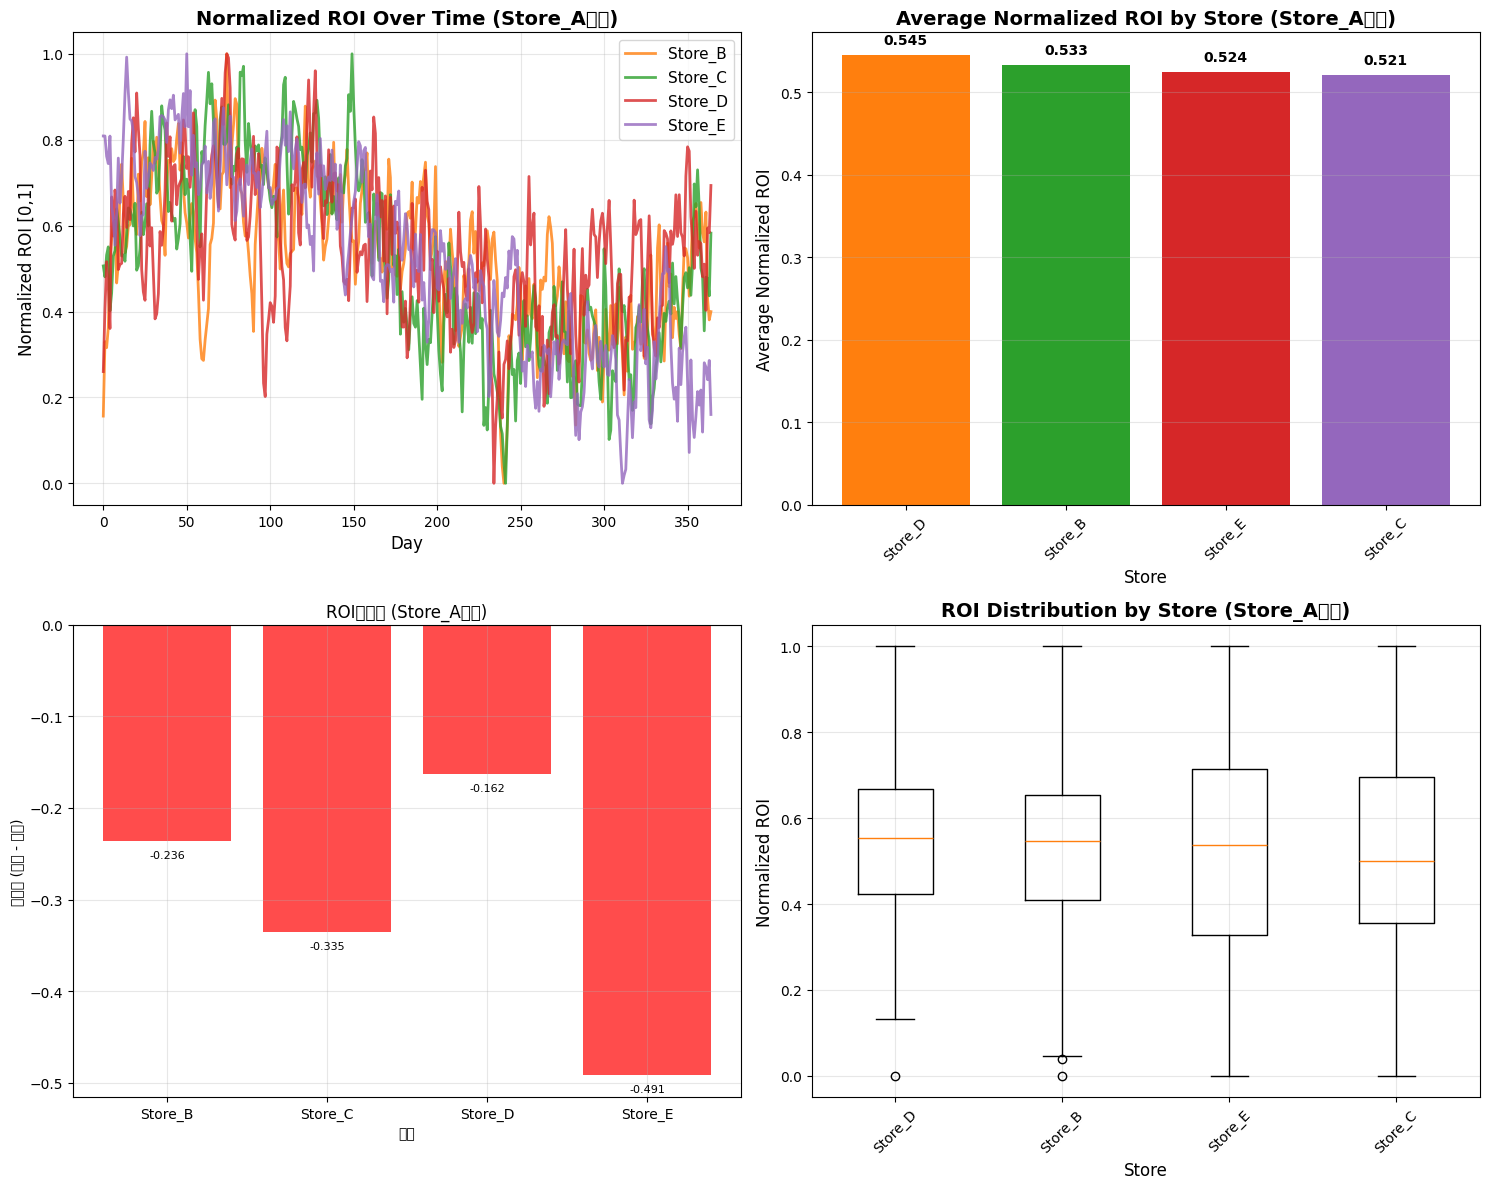

Store_Aを除いた分析グラフが生成されました！
保存先: /Users/harashimakoshi/CS332/332Project2/figures/analysis_without_store_a.png


In [10]:
# Store_Aを取り除いた分析
print("=== Store_Aを除いた分析 ===")
print()

# Store_Aを除いたデータ
data_without_a = final_data[final_data['store'] != 'Store_A'].copy()

print(f"元のデータ数: {len(final_data)}")
print(f"Store_Aを除いたデータ数: {len(data_without_a)}")
print(f"除外されたデータ数: {len(final_data) - len(data_without_a)}")
print()

# Store_Aを除いた各店舗の平均
print("=== Store_Aを除いた各店舗の平均ROI ===")
store_averages_no_a = data_without_a.groupby('store')['roi_normalized'].mean().sort_values(ascending=False)

for store, avg_roi in store_averages_no_a.items():
    print(f"{store}: {avg_roi:.4f}")

print()
print("=== 平均値のランキング (Store_A除く) ===")
for i, (store, avg_roi) in enumerate(store_averages_no_a.items(), 1):
    print(f"{i}. {store}: {avg_roi:.4f}")

print()
print("=== 統計サマリー (Store_A除く) ===")
print(f"全体平均: {data_without_a['roi_normalized'].mean():.4f}")
print(f"最高平均: {store_averages_no_a.max():.4f} ({store_averages_no_a.idxmax()})")
print(f"最低平均: {store_averages_no_a.min():.4f} ({store_averages_no_a.idxmin()})")
print(f"標準偏差: {store_averages_no_a.std():.4f}")

# Store_Aを除いた最初の100日と最後の100日の比較
print("\n=== Store_Aを除いた最初の100日 vs 最後の100日の比較 ===")
comparison_results_no_a = []

for store in data_without_a['store'].unique():
    store_data = data_without_a[data_without_a['store'] == store].sort_values('day')
    
    # 最初の100日
    first_100 = store_data.head(100)['roi_normalized'].mean()
    
    # 最後の100日
    last_100 = store_data.tail(100)['roi_normalized'].mean()
    
    # 変化量
    change = last_100 - first_100
    change_pct = (change / first_100) * 100 if first_100 != 0 else 0
    
    comparison_results_no_a.append({
        'store': store,
        'first_100_avg': first_100,
        'last_100_avg': last_100,
        'change': change,
        'change_pct': change_pct
    })
    
    print(f"{store}:")
    print(f"  最初の100日平均: {first_100:.4f}")
    print(f"  最後の100日平均: {last_100:.4f}")
    print(f"  変化量: {change:+.4f} ({change_pct:+.2f}%)")
    print()

# 可視化
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Store_Aを除いた時系列グラフ
ax1 = axes[0, 0]
colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
store_names_no_a = data_without_a['store'].unique()

for i, store in enumerate(store_names_no_a):
    store_data = data_without_a[data_without_a['store'] == store]
    ax1.plot(store_data['day'], store_data['roi_normalized'], 
             label=store, color=colors[i], linewidth=2, alpha=0.8)

ax1.set_title('Normalized ROI Over Time (Store_A除外)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Day', fontsize=12)
ax1.set_ylabel('Normalized ROI [0,1]', fontsize=12)
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3)

# 2. Store_Aを除いた平均値のバープロット
ax2 = axes[0, 1]
bars = ax2.bar(range(len(store_averages_no_a)), store_averages_no_a.values, 
               color=colors[:len(store_averages_no_a)])
ax2.set_title('Average Normalized ROI by Store (Store_A除外)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Store', fontsize=12)
ax2.set_ylabel('Average Normalized ROI', fontsize=12)
ax2.set_xticks(range(len(store_averages_no_a)))
ax2.set_xticklabels(store_averages_no_a.index, rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# バーの上に値を表示
for i, (bar, value) in enumerate(zip(bars, store_averages_no_a.values)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Store_Aを除いた変化量のバープロット
comparison_df_no_a = pd.DataFrame(comparison_results_no_a)
ax3 = axes[1, 0]
colors_change = ['green' if x > 0 else 'red' for x in comparison_df_no_a['change']]
bars = ax3.bar(comparison_df_no_a['store'], comparison_df_no_a['change'], 
               color=colors_change, alpha=0.7)
ax3.set_xlabel('店舗')
ax3.set_ylabel('変化量 (最後 - 最初)')
ax3.set_title('ROI変化量 (Store_A除外)')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.grid(True, alpha=0.3)

# バーの上に値を表示
for i, (bar, value) in enumerate(zip(bars, comparison_df_no_a['change'])):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.01 if value > 0 else -0.01), 
             f'{value:+.3f}', ha='center', va='bottom' if value > 0 else 'top', fontsize=8)

# 4. Store_Aを除いた箱ひげ図
ax4 = axes[1, 1]
store_data_list_no_a = [data_without_a[data_without_a['store'] == store]['roi_normalized'].values 
                        for store in store_averages_no_a.index]
ax4.boxplot(store_data_list_no_a, labels=store_averages_no_a.index)
ax4.set_title('ROI Distribution by Store (Store_A除外)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Store', fontsize=12)
ax4.set_ylabel('Normalized ROI', fontsize=12)
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/harashimakoshi/CS332/332Project2/figures/analysis_without_store_a.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("Store_Aを除いた分析グラフが生成されました！")
print("保存先: /Users/harashimakoshi/CS332/332Project2/figures/analysis_without_store_a.png")


In [11]:
# Store_Aを除いたデータを保存
print("=== Store_Aを除いたデータの保存 ===")
print()

# Store_Aを除いたデータを保存
output_path_no_a = '/Users/harashimakoshi/CS332/332Project2/data/espace_4stores_normalized.csv'
data_without_a.to_csv(output_path_no_a, index=False)

print(f"Store_Aを除いたデータが保存されました:")
print(f"保存先: {output_path_no_a}")
print(f"データ数: {len(data_without_a)} 行")
print(f"列数: {len(data_without_a.columns)} 列")
print()

# 保存されたデータの確認
print("=== 保存されたデータの確認 ===")
print("最初の5行:")
print(data_without_a.head())
print()

print("各店舗のデータ数:")
print(data_without_a['store'].value_counts().sort_index())
print()

print("各店舗の統計情報:")
print(data_without_a.groupby('store')['roi_normalized'].describe())
print()

# 比較用に元のデータ（Store_A含む）も保存
original_output_path = '/Users/harashimakoshi/CS332/332Project2/data/espace_5stores_normalized.csv'
final_data.to_csv(original_output_path, index=False)

print("=== データ保存完了 ===")
print(f"元のデータ（5店舗）: {original_output_path}")
print(f"Store_A除くデータ（4店舗）: {output_path_no_a}")
print()

# ファイルサイズの確認
import os
original_size = os.path.getsize(original_output_path)
no_a_size = os.path.getsize(output_path_no_a)

print("=== ファイルサイズ比較 ===")
print(f"元のデータ（5店舗）: {original_size:,} bytes")
print(f"Store_A除くデータ（4店舗）: {no_a_size:,} bytes")
print(f"サイズ差: {original_size - no_a_size:,} bytes")


=== Store_Aを除いたデータの保存 ===

Store_Aを除いたデータが保存されました:
保存先: /Users/harashimakoshi/CS332/332Project2/data/espace_4stores_normalized.csv
データ数: 1460 行
列数: 7 列

=== 保存されたデータの確認 ===
最初の5行:
     day    store    avg_diff       roi  roi_smoothed  roi_normalized  \
365    0  Store_B   35.843542  0.035844      0.035844        0.156521   
366    1  Store_B  104.895388  0.104895      0.056559        0.329847   
367    2  Store_B   50.979880  0.050980      0.054885        0.315842   
368    3  Store_B   73.197055  0.073197      0.060379        0.361806   
369    4  Store_B  124.460325  0.124460      0.079603        0.522656   

     avg_diff_normalized  
365             0.220458  
366             0.541191  
367             0.290763  
368             0.393958  
369             0.632067  

各店舗のデータ数:
store
Store_B    365
Store_C    365
Store_D    365
Store_E    365
Name: count, dtype: int64

各店舗の統計情報:
         count      mean       std  min       25%       50%       75%  max
store                         